In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Wed Jun 21 18:25:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   31C    P2    55W / 230W |   1480MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 8
n_outputs = 61
n_frames = 400
sr = 24000
fps = 30
train_csv_files = ['/Storage/speech/face/rvh_viseme2_1_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_2_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_3_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_4_iPhone_raw_30fps.csv',
                  ]
train_wav_files = ['/Storage/speech/face/rvh_viseme2_1_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_2_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_3_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_4_iPhone.wav',
                  ]

test_csv_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone_30fps.csv']
test_wav_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone.wav']

### Model

In [4]:
from model.model_flow1 import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, out_dim=n_outputs)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [5]:
save_dir = '/data/scpark/save/lips/train06.21-1/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 13000, model, None, optimizer)

total 4
-rw-rw-r-- 1 scpark scpark 40  6월 21 18:25 events.out.tfevents.1687339316.GPUSVR01


In [6]:
import torch
from data.dataset import LipsDataset, Collate

train_dataset = LipsDataset(train_wav_files, train_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=True)
print('train dataset :', len(train_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=1, shuffle=True, batch_size=8, 
                                           collate_fn=Collate(n_frames, n_mels))
print(train_loader)

test_dataset = LipsDataset(test_wav_files, test_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=False)
print('test dataset :', len(test_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, num_workers=1, shuffle=True, batch_size=8,
                                           collate_fn=Collate(n_frames, n_mels))
print(test_loader)

train dataset : 28308
test dataset : 1413


test : 0 0.9416627883911133
test : 1 0.9415545463562012
test : 2 0.9416105151176453
test : 3 0.9411824345588684
test : 4 0.9410966038703918
test : 5 0.9412044882774353
test : 6 0.9416573643684387
test : 7 0.9411848783493042
test : 8 0.9413478970527649
test : 9 0.9413902759552002
test_loss : 0.9413892030715942


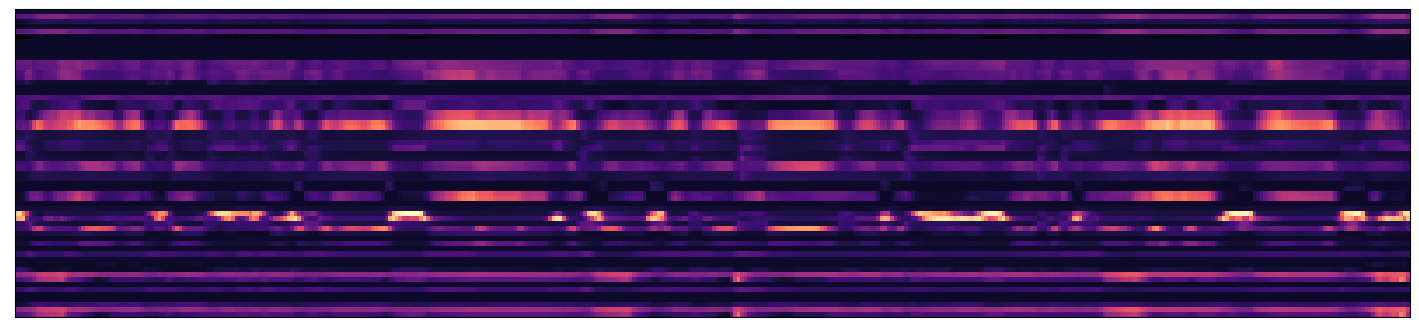

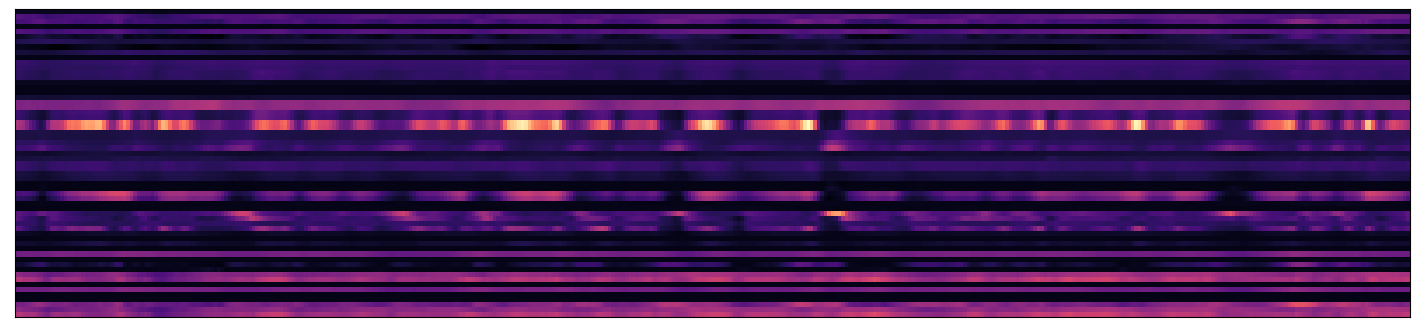

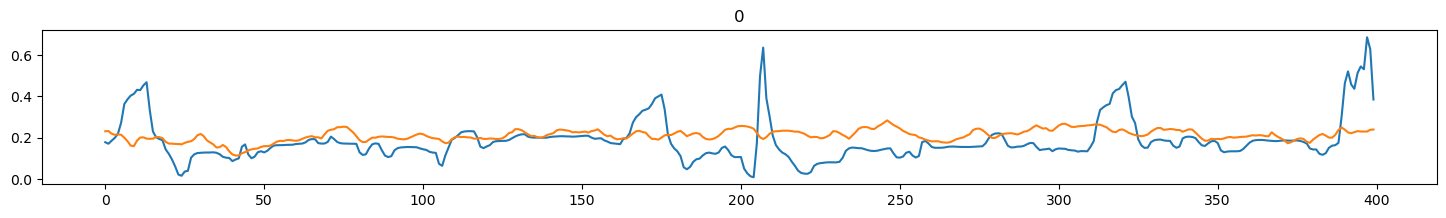

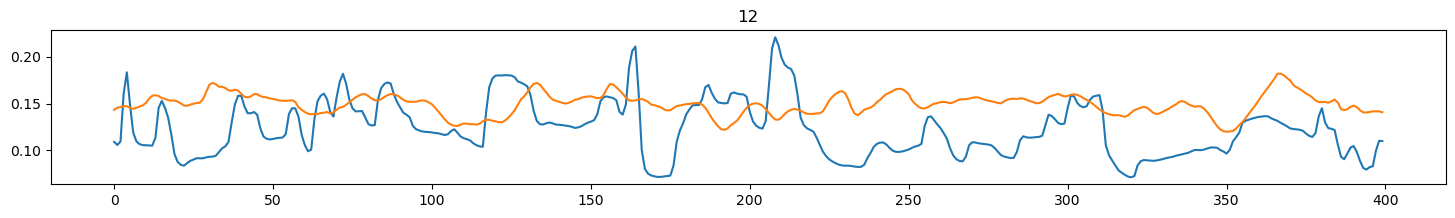

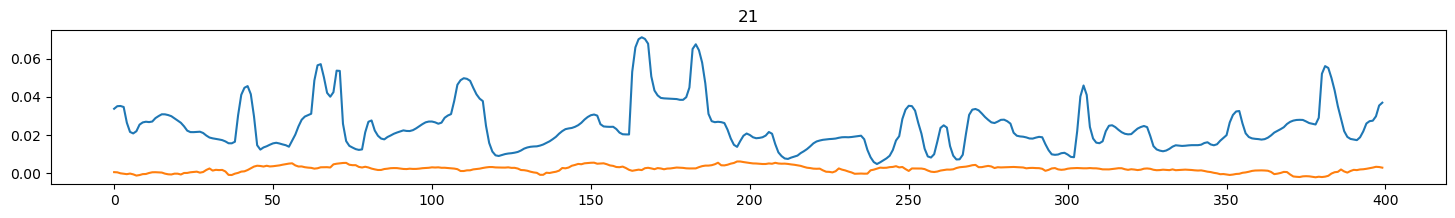

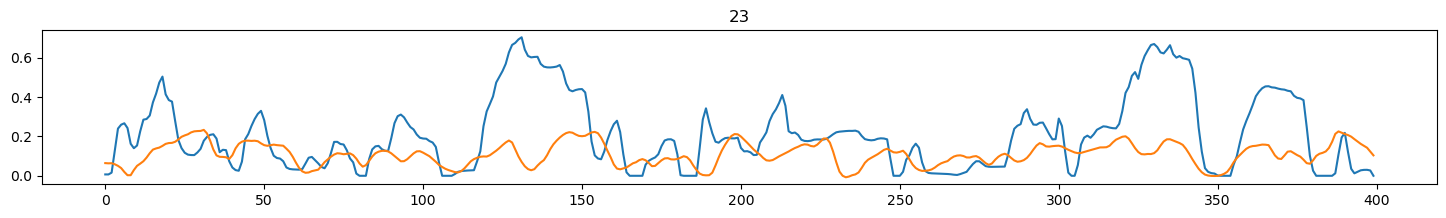

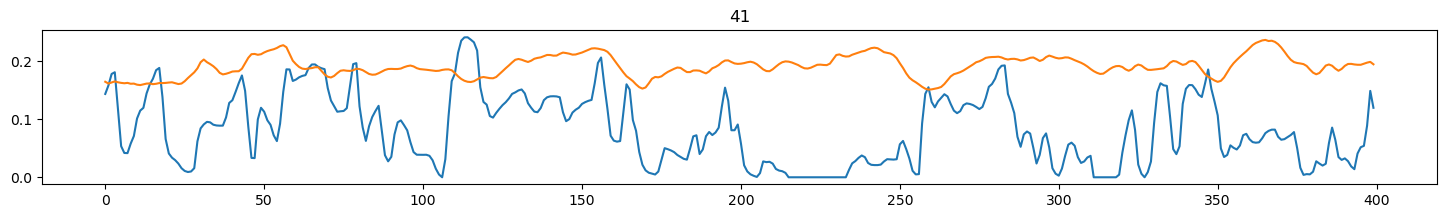

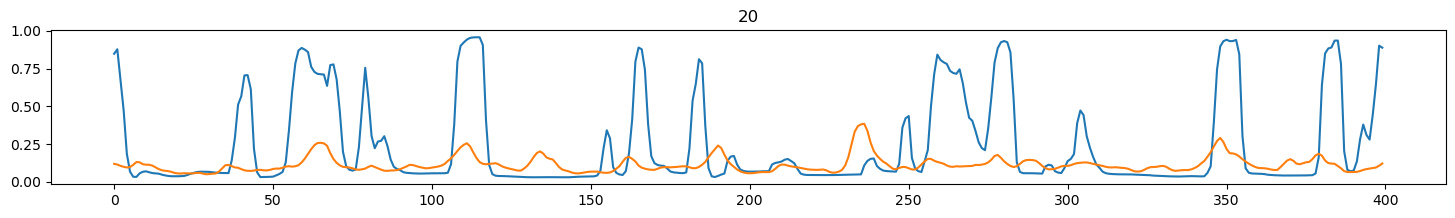

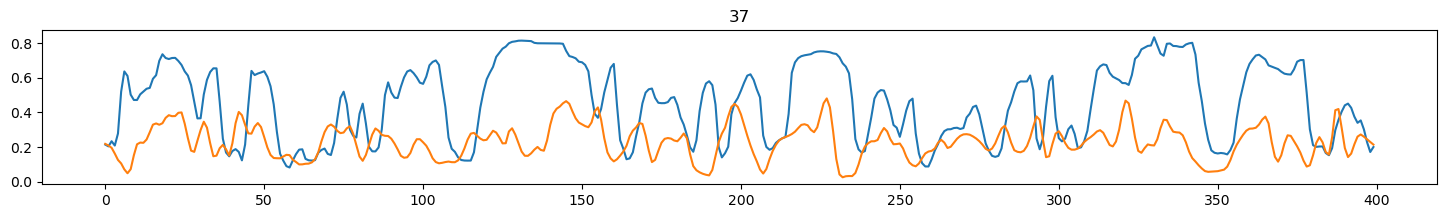

34401
34401 0.9206860065460205
34402
34402 0.9206309914588928
34403
34403 0.9206135272979736
34404
34404 0.9207382202148438
34405
34405 0.9207348227500916
34406
34406 0.9206593036651611
34407
34407 0.9207600951194763
34408
34408 0.9208841919898987
34409
34409 0.9208511114120483
34410
34410 0.9207813739776611
34411
34411 0.9206693172454834
34412
34412 0.9207031726837158
34413
34413 0.9207357168197632
34414
34414 0.9206019043922424
34415
34415 0.920769453048706
34416
34416 0.9206137657165527
34417
34417 0.9204913973808289
34418
34418 0.9205750823020935
34419
34419 0.9207625985145569
34420
34420 0.9205305576324463
34421
34421 0.9205916523933411
34422
34422 0.9205341339111328
34423
34423 0.920634388923645
34424
34424 0.9206754565238953
34425
34425 0.9205866456031799
34426
34426 0.9205854535102844
34427
34427 0.9206522703170776
34428
34428 0.9206121563911438
34429
34429 0.9208425283432007
34430
34430 0.9206068515777588
34431
34431 0.9207092523574829
34432
34432 0.9206799268722534
34433
3443

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = batch['inputs'].transpose(1, 2).to(device)
        targets = batch['outputs'].transpose(1, 2).to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets)
        
        print(step)
        loss = outputs['total_loss']
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 100 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 100 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = batch['inputs'].transpose(1, 2).to(device)
                targets = batch['outputs'].transpose(1, 2).to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets)
                    
                loss = outputs['total_loss']
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            with torch.no_grad():
                pred = model.inference(inputs)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [0, 12, 21, 23, 41]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(pred[0].data.cpu().numpy()[i])
                plt.show()
                
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 1000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [9]:
save(save_dir, step, model, None, optimizer)

saved /data/scpark/save/lips/train06.21-1/save_34328
